# Surface Mapping using Apriltags

In this notebook, we show how to use AprilTags to map from gaze-to screen coordinates. Along the way, we will also show some additional epoching functionalities.

To do so, we have collected a dataset where a participant freely views artworks presented on screen. Each artwork is shown for 4s, followed by a 0.5s inter trial intervall and a 0.5s central fixation cross. We can download this dataset using `get_sample_data()`.

In [5]:
import numpy as np

from pyneon import Recording, get_sample_data

# Load a sample recording
rec_dir = (
    get_sample_data("Artworks") / "Timeseries Data + Scene Video" / "artworks-9a141750"
)
rec = Recording(rec_dir)
print(rec)


Data format: cloud
Recording ID: 9a141750-95ca-48ee-9693-53bbb896b87e
Wearer ID: c4f68887-e96c-467f-a901-0fc9fce09c0a
Wearer name: JGH
Recording start time: 2025-06-16 12:49:27.817000
Recording duration: 357538000000 ns (357.538 s)



Let us take a closer look at the events file, populated with triggers sent during the initial viewing

In [6]:
event_data = rec.events.data
print(event_data.head(10))

               timestamp [ns]  \
event id                        
0         1750070967817000000   
1         1750070973028401000   
2         1750070973726906000   
3         1750070977877138000   
4         1750070978659847000   
5         1750070979391162000   
6         1750070983510925000   
7         1750070984367660000   
8         1750070985019038000   
9         1750070989241548000   

                                                       name       type  
event id                                                                
0                                           recording.begin  recording  
1                                            fixation onset  recording  
2          image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording  
3         image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording  
4                                            fixation onset  recording  
5          image onset 29a102da-4838-432b-7373-a3c7f5679d75  recording  
6         image off

We can see that the name column holds the information ofinterest to us. As the column ontains both information about the event_type as well as its name, we will first parse these apart. This process is a bit lengthy, but necessary to make sense of our data

In [7]:
# parse the name column, look for the key words image onset and image offset
def parse_event_name(name):
    if "image onset" in name.lower():
        type = "image onset"
        name = name.lower().replace("image onset ", "").strip()
    elif "image offset" in name.lower():
        type = "image offset"
        name = name.lower().replace("image offset ", "").strip()
    else:
        type = "other"
        name = None
    return type, name


for i, row in event_data.iterrows():
    type, name = parse_event_name(row["name"])
    event_data.at[i, "event_type"] = type
    event_data.at[i, "image_name"] = name

print(event_data.head(5))

               timestamp [ns]  \
event id                        
0         1750070967817000000   
1         1750070973028401000   
2         1750070973726906000   
3         1750070977877138000   
4         1750070978659847000   

                                                       name       type  \
event id                                                                 
0                                           recording.begin  recording   
1                                            fixation onset  recording   
2          image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording   
3         image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8  recording   
4                                            fixation onset  recording   

            event_type                            image_name  
event id                                                      
0                other                                  None  
1                other                                  None

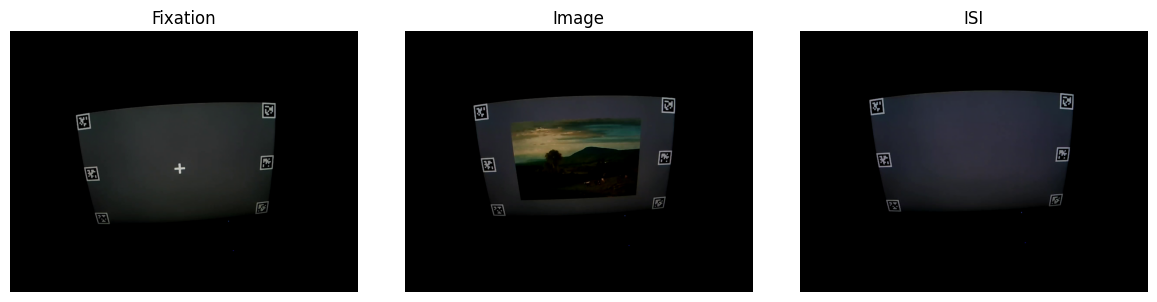

In [8]:
import matplotlib.pyplot as plt

video = rec.scene_video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(170, ax=axs[0], show=False)
video.plot_frame(200, ax=axs[1], show=False)
video.plot_frame(320, ax=axs[2], show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.tight_layout()
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 30 frames.

In [9]:
detected_markers = video.detect_markers(
    detection_window=(180, 210), detection_window_unit="frame"
)

Detecting markers: 100%|██████████| 31/31 [00:02<00:00, 10.90it/s]
C:\Users\qian.chu\Documents\GitHub\PyNeon\pyneon\tabular.py:66: UserWarning: Following columns not in known data types, using default data types: top left x [px], top left y [px], top right x [px], top right y [px], bottom right x [px], bottom right y [px], bottom left x [px], bottom left y [px]
  warn(


In [17]:
detected_markers.data.loc[detected_markers.ts[0]]

,frame id,marker id,top left x [px],top left y [px],top right x [px],top right y [px],bottom right x [px],bottom right y [px],bottom left x [px],bottom left y [px],center x [px],center y [px]
timestamp [ns],,,,,,,,,,,,
1750070974663577777,180,36h11_2,391.0,833.0,435.0,832.0,446.0,874.0,402.0,873.0,418.50,853.00
1750070974663577777,180,36h11_5,1135.0,781.0,1179.0,776.0,1172.0,817.0,1130.0,822.0,1154.00,799.00
1750070974663577777,180,36h11_1,340.0,624.0,386.0,621.0,397.0,672.0,350.0,674.0,368.25,647.75
1750070974663577777,180,36h11_4,1154.0,567.0,1199.0,564.0,1197.0,614.0,1150.0,619.0,1175.00,591.00
1750070974663577777,180,36h11_0,300.0,384.0,349.0,376.0,356.0,431.0,307.0,439.0,328.00,407.50
1750070974663577777,180,36h11_3,1160.0,323.0,1208.0,324.0,1208.0,379.0,1160.0,379.0,1184.00,351.25


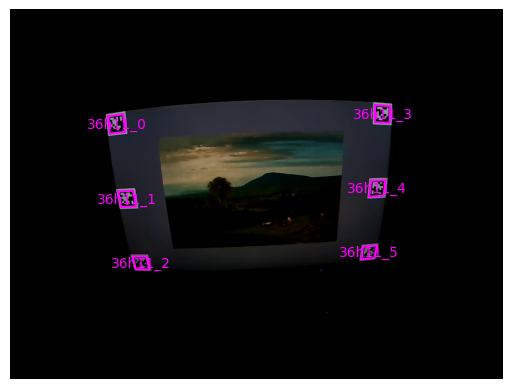

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [10]:
# Only get markers detected in frame
frame = 210
video.plot_detected_markers(
    detected_markers,
    frame_id=frame)

Having detected the markers (apriltags), we now need to provide information on the real-world coordinates of our markers. This is solved via a marker_info dataframe, which we generate below.

In [11]:
import pandas as pd


marker_ids = [0, 1, 2, 3, 4, 5]
marker_size = 300

win_half_width, win_half_height = np.array((1920, 1080)) / 2
half_marker_size = marker_size / 2

positions = [
    (
        -win_half_width + half_marker_size,
        win_half_height - half_marker_size,
    ),  # top-left
    (-win_half_width + half_marker_size, 0),  # middle-left
    (
        -win_half_width + half_marker_size,
        -win_half_height + half_marker_size,
    ),  # bottom-left
    (
        win_half_width - half_marker_size,
        win_half_height - half_marker_size,
    ),  # top-right
    (win_half_width - half_marker_size, 0),  # middle-right
    (
        win_half_width - half_marker_size,
        -win_half_height + half_marker_size,
    ),  # bottom-right
]

marker_corners = []
for pos in positions:
    cx, cy = pos
    corners = [
        [cx - half_marker_size, cy + half_marker_size],  # top-left
        [cx + half_marker_size, cy + half_marker_size],  # top-right
        [cx + half_marker_size, cy - half_marker_size],  # bottom-right
        [cx - half_marker_size, cy - half_marker_size],  # bottom-left
    ]
    marker_corners.append(corners)

marker_info = pd.DataFrame({"marker_id": marker_ids, "marker_corners": marker_corners})

In [12]:
print(marker_info)

   marker_id                                     marker_corners
0          0  [[-960.0, 540.0], [-660.0, 540.0], [-660.0, 24...
1          1  [[-960.0, 150.0], [-660.0, 150.0], [-660.0, -1...
2          2  [[-960.0, -240.0], [-660.0, -240.0], [-660.0, ...
3          3  [[660.0, 540.0], [960.0, 540.0], [960.0, 240.0...
4          4  [[660.0, 150.0], [960.0, 150.0], [960.0, -150....
5          5  [[660.0, -240.0], [960.0, -240.0], [960.0, -54...


With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [13]:
# cast index to np.ndarray
index = rec.gaze.data.index.to_numpy()
print(index[:10])

[1750070970217815359 1750070970222935359 1750070970227935359
 1750070970232948359 1750070970237935359 1750070970242942359
 1750070970247935359 1750070970252935359 1750070970257945359
 1750070970262941359]


In [14]:
homographies = rec.find_homographies(
    tag_info=tag_info,
    all_detections=all_detections,
    skip_frames=30,
    upsample_to="gaze",
    overwrite=True,
    max_gap=1,
)

NameError: name 'tag_info' is not defined

with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

In [ ]:
gaze_on_screen = rec.gaze_on_surface(homographies=homographies, overwrite=True)
fixations_on_screen = rec.fixations_on_surface(
    gaze_on_surface=gaze_on_screen, overwrite=True
)

In [ ]:
gaze_data = gaze_on_screen.data
fix_data = fixations_on_screen.data

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(
    gaze_data["gaze x [surface coord]"],
    gaze_data["gaze y [surface coord]"],
    s=1,
    alpha=0.5,
    c=gaze_data.index,
    cmap="viridis",
)

plt.scatter(
    fix_data["fixation x [surface coord]"],
    fix_data["fixation y [surface coord]"],
    s=1,
    c="black",
    label="Fixations",
)

plt.plot(
    [-600, 600, 600, -600, -600],
    [-400, -400, 400, 400, -400],
    color="red",
    label="Image outline",
)

plt.xlabel("X Coordinate (surface coord)")
plt.ylabel("Y Coordinate (surface coord)")

plt.xlim(-800, 800)
plt.ylim(-600, 600)